#### Importing libraries and setting up data

In [13]:
%reset -f

In [14]:
pip install pmdarima

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.holtwinters import Holt
import statsmodels.api as sm
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

In [16]:
# import warnings
# warnings.filterwarnings('ignore')
#warnings.resetwarnings()

In [17]:
set_style("whitegrid")

In [18]:
appl = yf.Ticker("AAPL")
df = appl.history(period="10y").reset_index().copy() #taking 10 years of stock data

In [19]:
df['Date'] = df['Date'].dt.strftime('%m/%d/%Y') #removing time from date and converting to string
df['Date'] = pd.to_datetime(df['Date'])  #converting back to date object
df = df[["Date","Close"]]
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

<ipython-input-19-339e032a7f9a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Date'].dt.year
<ipython-input-19-339e032a7f9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date'].dt.month


In [20]:
df_train = df[(df['Date']>datetime(2019,1,1))&(df['Date']<=datetime(2022,12,31))]
df_test = df[(df['Date']>datetime(2023,1,1))&(df['Date']<=datetime(2023,12,31))]

#### Data Exploration

Text(0.5, 1.0, 'Closing Price vs Date for each Year')

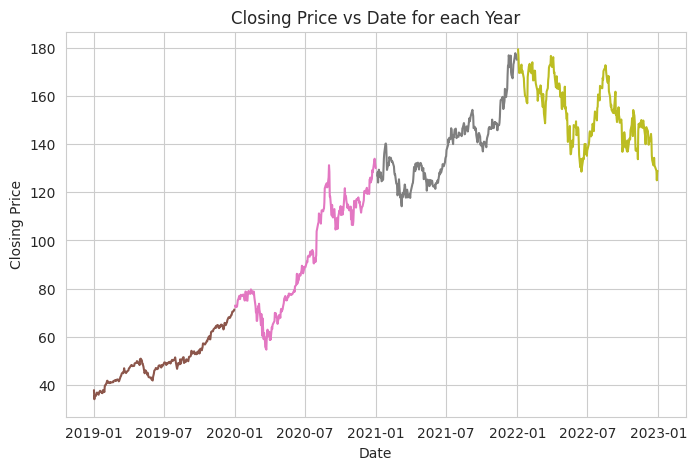

In [21]:
#@markdown Visualize dataset
plt.figure(figsize=(8,5))

for year in df['Year'].unique():
    yearly_data = df_train[df_train['Year']==year]
    plt.plot(yearly_data['Date'], yearly_data['Close'])

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price vs Date for each Year')
#plt.legend()

(-1.1, 1.1)

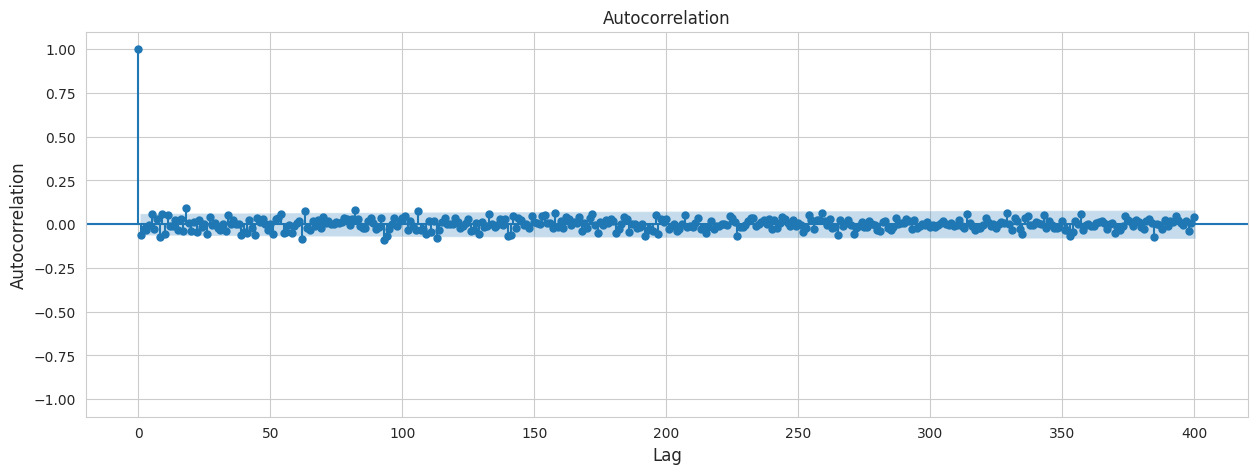

In [22]:
#@markdown Create acf plot after differencing the dataset once
fig, ax =  plt.subplots(1, 1, figsize=(15,5))

sm.graphics.tsa.plot_acf(df_train.Close.diff().values[1:],
                         lags = 400,
                         ax = ax)

plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)
plt.ylim(-1.1, 1.1)

#### Baseline - Linear Interpolation

In [23]:
# @title
# return the mean absolute error of the prediction on the test data
# relative to mean absolute error of the naive prediction on the training data
# If MASE > 1 then the prediction performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then the prediction performs better out of sample than naive forecast does in sample.

def mase(y_train_past, y_train, y_test, y_preds):
    n = len(y_train_past)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        past_val = y_train[i]
        future_val = y_train[i+m+1]
        interpolation = np.linspace(past_val,future_val, m+2)[1:-1]
        denom += np.abs(y_train[i+1:i+m+1] - interpolation).mean()
        #print("past_value_0:",past_val, "interpolation_0:", interpolation,"true_value_0:",y_train[i+1:i+m+1], "future_value_0", future_val)
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

#### Rolling average model

In [42]:
#@markdown Generate matrix of cross validation errors (errors are measured relative to linear interpolation)

test_size = 1 #@param {type:"slider", min:1, max:10, step:1}
theta = 0 #@param {type:"slider", min:0, max:1.57, step:0.1}

cv = TimeSeriesSplit(90, test_size=test_size)
start = 1
end = 20
ra_mase = np.zeros((90, len(range(start,end))))

i=0
for train_past_index, test_index in cv.split(df_train[:round(len(df_train)/2-1)]):
    max_index = len(df_train) - 1
    future_length = len(train_past_index)

    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index]#.reset_index().copy()
    hold_out = df_train.iloc[test_index]

    j = 0
    for q in range(start, end):
        # pred = past_tt.Close[-q:].mean() * np.ones(len(hold_out))
        pred = np.average([past_tt.Close.values[-q:].mean() * np.ones(len(hold_out)),
                        future_tt.Close.values[-q:].mean() * np.ones(len(hold_out))], axis=0, weights = [1,1])

        # my_average = (past_tt.Close.values[-1]+future_tt.Close.values[-1])/2
        #if q==1: print("past_value:", past_tt.Close.values[-1], "future_value", future_tt.Close.values[-1],"true_value:", hold_out.Close.values,"prediction:",pred, "average:", (past_tt.Close.values[-1]+future_tt.Close.values[-1])/2)

        ra_mase[i,j] = mase(past_tt.Close.values, df_train.Close.values, hold_out.Close.values, pred)
        j = j+1
    i = i+1

    # print("past_train:", train_past_index[-5:], "test:", test_index, "future_train:", train_future_index[-5:])
    # print("past_train_len:", len(train_past_index), "test_len:", len(test_index), "future_train_len:", len(train_future_index))




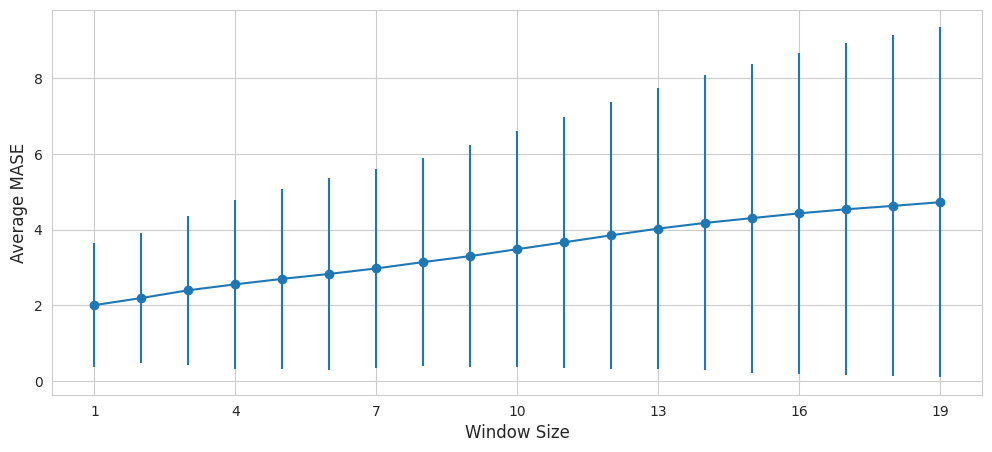


 The window size that minimized the avgerage cv mean absolute square error (MASE) was  1 . It had a mean cv MASE of 2.003


In [43]:
#@markdown Plot mean cross validation error for different window sizes

plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))
plt.errorbar(range(start,end), np.mean(ra_mase, axis=0), yerr=np.std(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

print("\n The window size that minimized the avgerage cv mean absolute square error (MASE) was ",
      range(start,end)[np.argmin(np.mean(ra_mase, axis=0))],
      "\b. It had a mean cv MASE of",
      np.round(np.min(np.mean(ra_mase, axis=0)), 3))

#### A double exponential Smoothing Model

In [44]:
#@markdown Generate matrix of cross validation errors (errors are measured relative to linear interpolation)

test_size = 1 #@param {type:"slider", min:1, max:10, step:1}

exp_cv = TimeSeriesSplit(90, test_size=test_size)

exp_mase = np.zeros((90))

smoothing_level_past = []
smoothing_trend_past = []

smoothing_level_future = []
smoothing_trend_future = []

i = 0

for train_past_index, test_index in exp_cv.split(df_train[:round(len(df_train)/2-1)]):
    max_index = len(df_train) - 1
    future_length = len(train_past_index)
    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index].reset_index().copy()
    hold_out = df_train.iloc[test_index]

    exp_smooth_past = Holt(past_tt.Close.values).fit(optimized=True)
    smoothing_level_past.append(exp_smooth_past.params['smoothing_level'])
    smoothing_trend_past.append(exp_smooth_past.params['smoothing_trend'])

    exp_smooth_future = Holt(future_tt.Close.values).fit(optimized=True)
    smoothing_level_future.append(exp_smooth_future.params['smoothing_level'])
    smoothing_trend_future.append(exp_smooth_future.params['smoothing_trend'])

    impute_from_past = exp_smooth_past.forecast(len(hold_out))
    impute_from_future = exp_smooth_future.forecast(len(hold_out))[::-1]
    pred = [(impute_from_past[j]+impute_from_future[j])/2 for j in range(len(hold_out))]

    #print("impute from past", impute_from_past, "impute_from_future", impute_from_future)
    exp_mase[i] = mase(past_tt.Close.values, df_train.Close.values, hold_out.Close.values, pred)
    i = i + 1



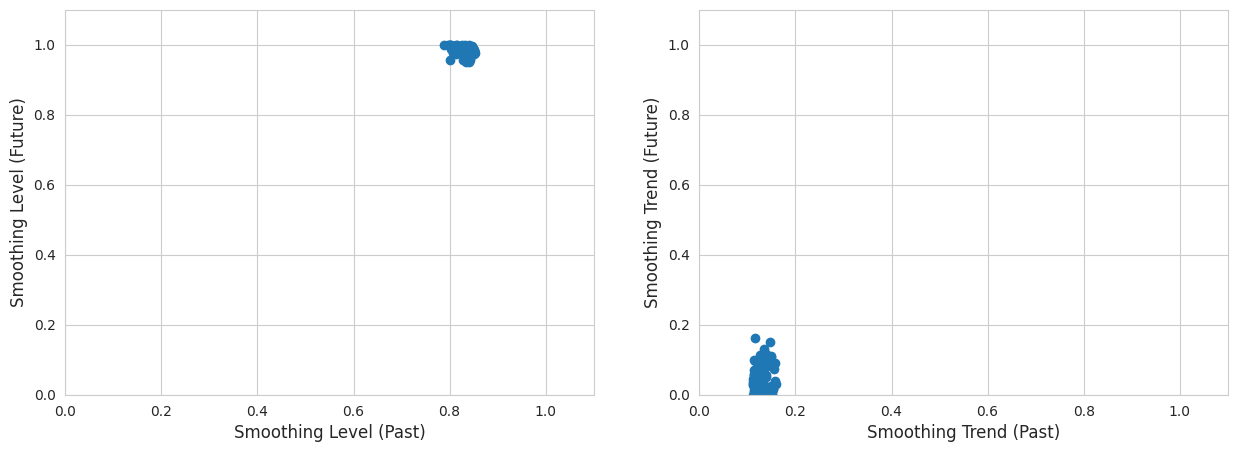

The mean mase is 2.06 and the standard deviation is  1.68 
The optimal smoothing level for past data is  0.84 and the optimal smoothing trend for past data is  0.13 
The optimal smoothing level for future data is  0.98 and the optimal smoothing trend for future data is  0.05


In [45]:
#@markdown Plot the optimal values for the smoothing level and the smoothing trend
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.scatter(smoothing_level_past, smoothing_level_future )

plt.xlabel("Smoothing Level (Past)", fontsize=12)
plt.ylabel("Smoothing Level (Future)", fontsize=12)
plt.ylim(0,1.1)
plt.xlim(0,1.1)


plt.subplot(1,2,2)

plt.scatter(smoothing_trend_past, smoothing_trend_future )

plt.xlabel("Smoothing Trend (Past)", fontsize=12)
plt.ylabel("Smoothing Trend (Future)", fontsize=12)
plt.ylim(0,1.1)
plt.xlim(0,1.1)

plt.show()

print("The mean mase is", round(exp_mase.mean(),2),
      "and the standard deviation is ", round(exp_mase.std(),2),
      "\nThe optimal smoothing level for past data is ", round(np.mean(smoothing_level_past),2),
      "and the optimal smoothing trend for past data is ", round(np.mean(smoothing_trend_past),2),
      "\nThe optimal smoothing level for future data is ", round(np.mean(smoothing_level_future),2),
      "and the optimal smoothing trend for future data is ", round(np.mean(smoothing_trend_future),2),)

#### ARIMA Model

In [46]:
#@markdown optimal parameters for ARIMA model

auto_arima(df_train.Close.values, trace=False, max_p=5, max_q=5)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [47]:
#@markdown Generate matrix of cross validation errors and print out mean absolute square errror and its standard deviation

test_size = 1 #@param {type:"slider", min:1, max:10, step:1}

arima_cv = TimeSeriesSplit(90, test_size=test_size)
arima_mase = np.zeros(90)

i = 0

for train_past_index, test_index in arima_cv.split(df_train[:round(len(df_train)/2-1)]):
    max_index = len(df_train) - 1
    future_length = len(train_past_index)
    train_future_index = np.arange(test_index[-1] + 1, test_index[-1] + 1 + future_length)
    train_future_index = train_future_index[train_future_index <= max_index][::-1]

    past_tt = df_train.iloc[train_past_index]
    future_tt = df_train.iloc[train_future_index].reset_index().copy()
    hold_out = df_train.iloc[test_index]

    arima_past = ARIMA(past_tt.Close.values, order=(0,1,1)).fit()
    arima_future = ARIMA(future_tt.Close.values, order=(0,1,1)).fit()

    impute_from_past = arima_past.forecast(len(hold_out))
    impute_from_future = arima_future.forecast(len(hold_out)) [::-1]

    pred = [(impute_from_past[j]+impute_from_future[j])/2 for j in range(len(hold_out))]

    #print("impute from past", impute_from_past, "impute_from_future", impute_from_future)
    arima_mase[i] = mase(past_tt.Close.values, df_train.Close.values, hold_out.Close.values, pred)

    i=i+1

print("The mean mase is", round(arima_mase.mean(),2),
      "and the standard deviation is ", round(arima_mase.std(),2))


The mean mase is 2.0 and the standard deviation is  1.65
